attention: before running this file make sure to cutoff all unecessary data!

this should only include data with a minimum velocity abouve 0.01 so it should be usable without removing no motion data

Nur dieses skript nutzen

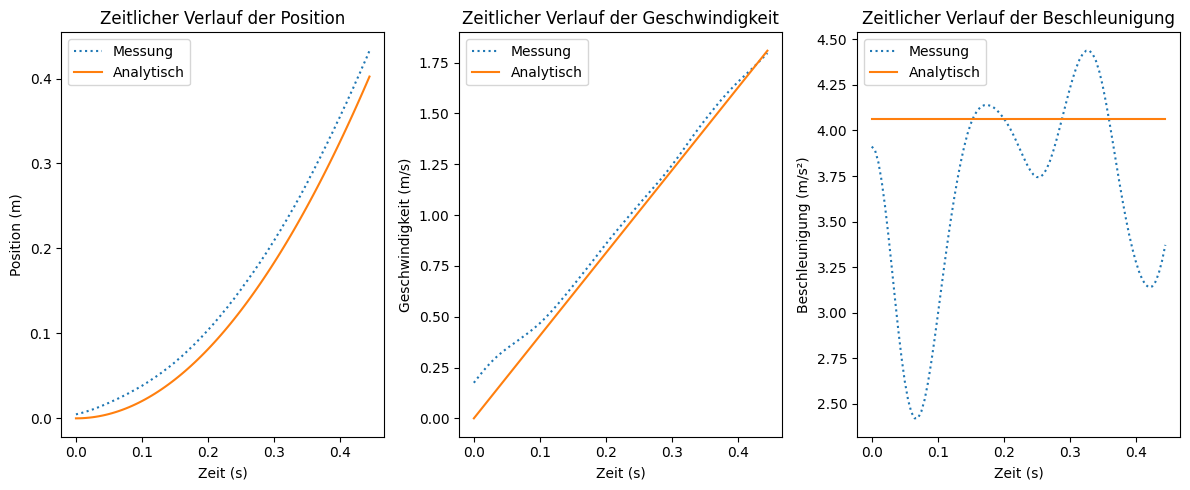

Berechneter Rollreibungskoeffizient : 0.047
Luftwiderstandskraft: 0.009881 N
Hangabtriebskraft Fg= :0.474 N
Verhältnis der Luftwiderstandskraft zur Hangabtriebskraft: 0.021


In [86]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Physikalische Konstanten und Parameter
m= 0.1167  # Masse in kg schwer
#m=0.06638 # Masse in KG leer
g = 9.81  # Erdbeschleunigung in m/s²
theta = np.radians(24.47)  # Umwandlung in Bogenmaß

# 🛠 Einstellbare Parameter
t_offset = 0 # Zeitverschiebung der analytischen Lösung (s)
cut_start = 0.15  # Anfang der Messdaten abschneiden (s)
cut_end = 0.6# Ende der Messdaten abschneiden (s), z.B. 1.5 oder None

# Messdaten laden
file_path = "kunststoff_mit_gewicht_24_47.csv"
df = pd.read_csv(file_path)

# Zeit relativ zum Startzeitpunkt der Messdaten
t_raw = df["Zeit (s)"].values
t0 = t_raw[0]
t_relative = t_raw - t0

# Daten zuschneiden
mask = t_relative >= cut_start
if cut_end is not None:
    mask &= t_relative <= cut_end

df_cut = df[mask].copy()
t = t_relative[mask]
t = t - t[0]  # Zeit wieder bei 0 starten lassen

# Analytische Lösung berechnen mit Zeitverschiebung
t_shifted = t - t_offset
a_0 = g * np.sin(theta)
x_analytisch_full = 0.5 * a_0 * t_shifted**2
v_analytisch_full = a_0 * t_shifted
a_analytisch_full = np.full_like(t_shifted, a_0)

# Nur Zeiten, bei denen x <= 1 m und t_shifted >= 0
valid = (t_shifted >= 0) & (x_analytisch_full <= 1.0)
t_cut = t[valid]
x_analytisch = x_analytisch_full[valid]
v_analytisch = v_analytisch_full[valid]
a_analytisch = a_analytisch_full[valid]

# Plot
plt.figure(figsize=(12, 5))

# Position
plt.subplot(1, 3, 1)
plt.plot(t, df_cut["Gefilterte Position (m)"], label="Messung", linestyle="dotted")
plt.plot(t_cut, x_analytisch, label="Analytisch", linestyle="solid")
plt.xlabel("Zeit (s)")
plt.ylabel("Position (m)")
plt.legend()
plt.title("Zeitlicher Verlauf der Position")

# Geschwindigkeit
plt.subplot(1, 3, 2)
plt.plot(
    t, df_cut["Gefilterte Geschwindigkeit (m/s)"], label="Messung", linestyle="dotted"
)
plt.plot(t_cut, v_analytisch, label="Analytisch", linestyle="solid")
plt.xlabel("Zeit (s)")
plt.ylabel("Geschwindigkeit (m/s)")
plt.legend()
plt.title("Zeitlicher Verlauf der Geschwindigkeit")

# Beschleunigung
plt.subplot(1, 3, 3)
plt.plot(
    t, df_cut["Gefilterte Beschleunigung (m/s²)"], label="Messung", linestyle="dotted"
)
plt.plot(t_cut, a_analytisch, label="Analytisch", linestyle="solid")
plt.xlabel("Zeit (s)")
plt.ylabel("Beschleunigung (m/s²)")
plt.legend()
plt.title("Zeitlicher Verlauf der Beschleunigung")

plt.tight_layout()
plt.savefig(f"fig_{file_path}.png")

plt.show()

# Rollreibungskoeffizient berechnen (aus zugeschnittenen Daten)
bewegte_daten = df_cut[df_cut["Gefilterte Geschwindigkeit (m/s)"] > 0.00101]
a_mittel_neu = bewegte_daten["Gefilterte Beschleunigung (m/s²)"].mean()
mu_r_neu = (g * np.sin(theta) - a_mittel_neu) / (g * np.cos(theta))
print(f"Berechneter Rollreibungskoeffizient : {mu_r_neu:.3f}")

# Luftwiderstand abschätzen
rho_air = 1.225  # kg/m³
A = 0.01  # m²
C_d = 0.5

v_max = df_cut["Gefilterte Geschwindigkeit (m/s)"].max()
F_L = 0.5 * rho_air * A * C_d * v_max**2
F_g = m * g * np.sin(theta)
F_L_ratio = F_L / F_g

print(f"Luftwiderstandskraft: {F_L:.6f} N")
print(f"Hangabtriebskraft Fg= :{F_g:.3f} N")
print(f"Verhältnis der Luftwiderstandskraft zur Hangabtriebskraft: {F_L_ratio:.3f}")